In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl


FONT_SIZE = 12
AXES_SIZE = FONT_SIZE * 1.5
TICK_SIZE = FONT_SIZE * 1.25
LEGEND_SIZE = FONT_SIZE

my_rcParams = {
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 5,
    "font.size": FONT_SIZE,
    "font.family": "Helvetica",
    "axes.titlesize": AXES_SIZE,
    "axes.labelsize": AXES_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "xtick.major.pad": FONT_SIZE / 2,
    "ytick.major.pad": FONT_SIZE / 2,
}

for k, v in my_rcParams.items():
    mpl.rcParams[k] = v

In [3]:
DATE_MIN = ...
DATE_MAX = ...

In [4]:
# Filter to sequences in this date range
# Group by country
# Plot average number of sequences per week in range

In [5]:
# https://data.nextstrain.org/files/ncov/open/metadata.tsv.gz
raw_metadata_reader = pd.read_csv(
    "../data/gisaid_metadata_pruned.tsv", 
    sep="\t",
    usecols=(
        "strain",
        "date",
        "date_submitted",
        "country",
        "division",
        "Nextstrain_clade"
        ),
    dtype={
        "country": "category",
        "division": "category",
        "Nextstrain_clade": "category",
        },
    chunksize=100000)

In [6]:
# Countries of interest
# All countries in order and then highlight countries of interest
#locations = ["USA", "Japan", "United Kingdom", "Australia", "Brazil", "South Africa"]
start_date = "2022-01-01"
end_date = "2022-12-31"

# Borrowing from John here
def clean_metadata(metadata):
    # Filter to countries
    #metadata = metadata[metadata["country"].isin(locations)]
    
    # Remove ambigious dates
    unambiguous_dates = (metadata["date"] != "?") & (metadata["date"].str.count("-") == 2)
    unambiguous_dates = unambiguous_dates & ~(metadata["date"].str.contains("X", na=True))
    metadata = metadata[unambiguous_dates].copy()
    
    # Filter to date range
    metadata["date"] = pd.to_datetime(metadata["date"])
    metadata["date_submitted"] = pd.to_datetime(metadata["date_submitted"])

    date_since_start_date = (metadata["date"] >= start_date)
    date_before_end_date = (metadata["date"] <= end_date)
    metadata = metadata[(date_since_start_date) & (date_before_end_date)].copy()
        
    # Filter records without NS clade
    metadata = metadata[~pd.isnull(metadata["Nextstrain_clade"])].copy()
    
    # Remove airport strain
    metadata = metadata[~(metadata["strain"].str.startswith("Japan/IC-"))]
    return metadata

In [7]:
metadata_chunks = [clean_metadata(chunk) for chunk in raw_metadata_reader]

In [8]:
metadata = pd.concat(metadata_chunks, ignore_index=True)
metadata

,strain,date,date_submitted,country,division,Nextstrain_clade
0,Afghanistan/barcode01/2022,2022-04-03,2022-09-21,Afghanistan,Kandahar,21M (Omicron)
1,Afghanistan/barcode02/2022,2022-03-28,2022-09-21,Afghanistan,Kandahar,19A
2,Afghanistan/barcode03/2022,2022-04-03,2022-09-21,Afghanistan,Kandahar,19A
3,Afghanistan/barcode04/2022,2022-04-05,2022-09-21,Afghanistan,Kandahar,21L (Omicron)
4,Afghanistan/barcode05/2022,2022-04-05,2022-09-21,Afghanistan,Kandahar,19A
...,...,...,...,...,...,...
6712273,spain/PV-HUB-53446890/2022,2022-06-30,2022-07-06,Spain,Basque Country,21L (Omicron)
6712274,syrianhamster/India/DL-ICMR-MCL-22-856-HAM43LU...,2022-01-07,2022-07-18,India,Delhi,21L (Omicron)
6712275,syrianhamster/India/DL-ICMR-MCL-22-856-HAM43LU...,2022-01-07,2022-07-18,India,Delhi,21L (Omicron)
6712276,tiger/USA/FL-22-000348-001/2022,2022-01-02,2022-03-04,USA,Florida,21J (Delta)


In [9]:
weekly_sequences = (metadata
        .groupby(["country", pd.Grouper(key='date', freq='W')])
        .size()
        .to_frame("sequences_per_week")
        .reset_index())
weekly_sequences = weekly_sequences.sort_values("sequences_per_week")

In [10]:
plot_df = weekly_sequences.groupby("country")["sequences_per_week"].mean().to_frame("mean_seq_per_week").reset_index()
plot_df = plot_df.sort_values("mean_seq_per_week")

#TODO: Export for plotting

In [16]:
plot_countries = ["USA", "Japan", 
                  "United Kingdom", "France", 
                  "Germany", 
                  "Mexico",
                  "Colombia",
                  "Chile",
                  "Argentina",
                  "China", "Australia", 
                  "Brazil", "South Africa",
                  "Nigeria",
                  "Ghana",
                  "Senegal",
                  "Egypt",
                  "Morocco",
                  "South Korea",
                  "Vietnam",
                  "Philippines",
                  "Singapore",
                  "Malaysia",
                  "India",
                  "Pakistan",
                  "Spain",
                  "Portugal"]
_plot_df = plot_df[plot_df.country.isin(plot_countries)]

In [19]:
THRESES = [ 100,  500, 1000, 2000, 5000]

In [22]:
[1, 10, 100, 1000, 10_000] + THRESES

[1, 10, 100, 1000, 10000, 100, 500, 1000, 2000, 5000]

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_5953/3127531304.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Average weekly sequences in 2022')

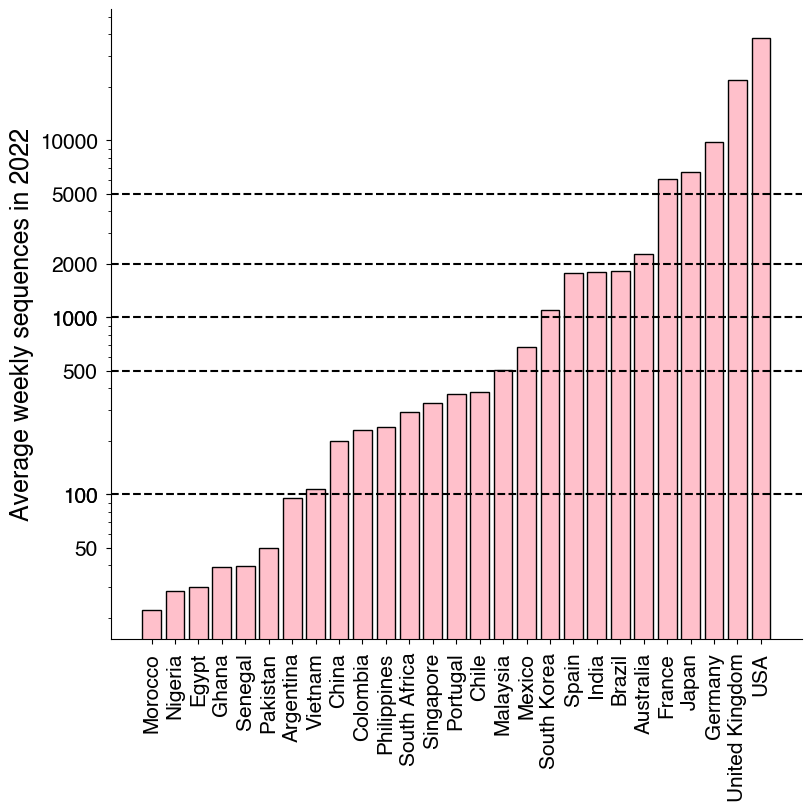

In [31]:
fig = plt.figure(figsize=(8., 8.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0])

ax.bar(_plot_df.country, _plot_df.mean_seq_per_week, ec="k", color="pink")

ax.set_yscale("log")
ax.set_yticks([50, 100, 1000, 10_000] + THRESES)
ax.set_yticklabels([50, 100, 1000, 10_000] + THRESES)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for thres in THRESES:
    ax.axhline(y=thres, linestyle ="--", color="k", linewidth=1.5)

ax.set_ylabel("Average weekly sequences in 2022")
    